## CuffDiff Summary
### Author: Xiang Li



In [1]:
import numpy as np
import pandas as pd
import os


In [48]:
import datetime
str(datetime.date.today())


'2019-01-21'

In [11]:
#### Generate DEGs Seperately
#os.makedirs(os.getcwd()+'/genelist/')
PATH_FOLDER=os.getcwd()+ '/CuffDiff_Results/'
INPUT_LIST=os.listdir(PATH_FOLDER)
for input_name in INPUT_LIST:
    INPUT_PATH = PATH_FOLDER+input_name
    print ('Library:' + input_name)
    df_up = generate_Upregulated_Genes(INPUT_PATH)
    df_up.to_csv( os.getcwd()+'/genelist/up_'+input_name +'.bed' ,sep='\t')
    print ('# of Up:' )
    print(df_up.shape)
    
    df_down = generate_Downregulated_Genes(INPUT_PATH)  
    df_down.to_csv( os.getcwd()+'/genelist/down_'+input_name + '.bed' ,sep='\t')
    print ('# of Down')
    print(df_down.shape)
    print ('')


Library:Eed_KO_vs_Eed_WT
# of Up:
(131, 6)
# of Down
(32, 6)

Library:Hdac12_KO_vs_Hdac12_WT
# of Up:
(202, 6)
# of Down
(274, 6)



In [90]:
# For any input of /gene_exp.diff, return its All genes with
### gene_id, cond1, cond2, log2(fold_change), p_value, plus a number of order.
def generate_All_Genes(Input_Path, number):
#### READ FILE
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2','value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Rename columns
    df=df.rename(columns={'test_id':'gene_id', 'value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output   
    return df.loc[:,['gene_id',df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)',
                     'p_value','q_value', 'End_'+str(number), '||']].fillna('')
####################################################################################

## DEGS

### For any input of /gene_exp.diff, return its up_DEGs genes with
### gene_id, cond1, cond2, log2(fold_change), p_value, plus a number of order.
### Parameters for DEGs:
FC_UP=2.0
q_value_less=0.05
FPKM_threshold=1.0
####################################################################################


def generate_Upregulated_Genes(Input_Path):
#### READ FILE
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2', 'value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Filter
    df=df[(df['status']=='OK') & (df['q_value']<=q_value_less) & (df['value_2']>=FPKM_threshold) & (df['log2(fold_change)'] >= np.log2(FC_UP))]
#### Rearrange Columns
    df=df.rename(columns={'test_id':'gene_id','value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output
    return df.loc[:,['gene_id', df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)','p_value','q_value']]
####################################################################################

def generate_Downregulated_Genes(Input_Path):
#### READ FILE FROM CuffDiff Results
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2', 'value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Filter
    df=df[(df['status']=='OK') & (df['q_value']<=q_value_less) & (df['value_1']>=FPKM_threshold) & (df['log2(fold_change)']<= -np.log2(FC_UP))]   
#### Rearrange Columns
    df=df.rename(columns={'test_id':'gene_id','value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output
    return df.loc[:,['gene_id', df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)','p_value','q_value']]


#### Functions to read /genes.read_group_tracking and output FPKM
def generate_genes_FPKM_df(Input_Path):
    df = pd.read_csv(Input_Path+'/genes.read_group_tracking', sep='\t', header=0)
    FPKM_df = None
    for cond in df['condition'].unique():
        for replica in df[df['condition'] == cond]['replicate'].unique():
            #print (cond, replica)
            temp_df = (df[ (df['condition'] == cond) & (df['replicate'] == replica)].loc[:,['tracking_id', 'FPKM']])
            cond_name= cond+'_'+str(replica)
            temp_df.rename(columns={'tracking_id': 'gene_id', 'FPKM': cond_name }, inplace=True)
            if FPKM_df is None:
                FPKM_df
                FPKM_df = temp_df  
            else:
                FPKM_df = FPKM_df.merge(temp_df, on='gene_id', how='outer', suffixes=('','_'))
    return FPKM_df

def Add_common_header(df,common_header):
    name_list=[common_header]*len(df.columns)
    tuples = list(zip(name_list,df.columns))
    df.columns = pd.MultiIndex.from_tuples(tuples)
    return df


def DIR_CHECK_CREATE(Input_Path):
    if (not os.path.isdir(Input_Path)):
        print ("New Dir Made is" + Input_Path)
        os.mkdir(Input_Path)
    else: 
        print ('Dir Exists')
    return None
        
def Summary_Expression(Cuffdiff_Path, output_name):
    import datetime
    PATH_FOLDER=Cuffdiff_Path+ '/CuffDiff_Results'
    OUT_FOLDER=Cuffdiff_Path+'/CuffDiff_Results_Summary'

    DIR_CHECK_CREATE(PATH_FOLDER)
    DIR_CHECK_CREATE(OUT_FOLDER)

    INPUT_LIST=[f for f in os.listdir(PATH_FOLDER) if not f.startswith('.')]
    writer = pd.ExcelWriter(OUT_FOLDER+output_name+'_CuffDiff_Summary_'+str(datetime.date.today())+ '.xlsx', engine='xlsxwriter')

    i=0
    for input_name in INPUT_LIST[:]:
        INPUT_PATH = PATH_FOLDER+'/'+input_name
        print INPUT_PATH
        if (i==0):
            df_all=generate_genes_FPKM_df(INPUT_PATH)
            df_all[input_name]=''
            df_all = df_all.merge(generate_All_Genes(INPUT_PATH,i+1), on='gene_id', how='inner', suffixes=('','_')) 
            i+=1
            continue
        df_all = df_all.merge(generate_genes_FPKM_df(INPUT_PATH), on='gene_id', how='inner', suffixes=('','_'))
        df_all[input_name]=''
        df_all = df_all.merge(generate_All_Genes(INPUT_PATH,i+1), on='gene_id', how='inner', suffixes=('','_')) 

        i+=1
    df_all.to_excel(writer, sheet_name='All_Genes', index=None)

    ###### Generating a DEGs list in the last.
    DEGs_List=pd.DataFrame([],columns=['gene_id'])
    
    for input_name in INPUT_LIST:
        INPUT_PATH = PATH_FOLDER+'/'+input_name
        print ('Library:' + input_name)
        df_up = generate_genes_FPKM_df(INPUT_PATH)
        df_up[input_name]=''
        df_up = df_up.merge(generate_Upregulated_Genes(INPUT_PATH), on='gene_id', how='inner', suffixes=('','_'))
        df_up.to_excel( writer, sheet_name='up_'+input_name, index=None)

        DEGs_List=pd.concat([DEGs_List,df_up[['gene_id']]])
        print ('# of Up:' )
        print(df_up.shape)

        df_down = generate_genes_FPKM_df(INPUT_PATH)
        df_down[input_name]=''
        df_down = df_down.merge(generate_Downregulated_Genes(INPUT_PATH), on='gene_id', how='inner', suffixes=('','_')) 
        df_down.to_excel( writer, sheet_name='down_'+input_name,index=None)
        DEGs_List=pd.concat([DEGs_List,df_down[['gene_id']]])
        print ('# of Down')
        print(df_down.shape)
        print ('')

    print ("Total Number of DEGs is:" + str(len(DEGs_List['gene_id'].unique())))

    DEGs_List = pd.DataFrame( list(DEGs_List['gene_id'].unique()), columns=['gene_id'])
    DEGs_List.to_excel( writer, sheet_name='Union_DGEs_List',index=None)
    writer.save()
    ### Output A Excel Summary Completed!
    All_Gene_List = pd.DataFrame( list(df_all['gene_id'].unique()), columns=['gene_id'])
    
    df_DEGs=DEGs_List
    df_All_Genes=All_Gene_List
    for input_name in INPUT_LIST[:]:
        INPUT_PATH = PATH_FOLDER+'/'+input_name
        print ('Library:' + input_name)
        df_DEGs = df_DEGs.merge(generate_genes_FPKM_df(INPUT_PATH), on='gene_id',how='inner')
        df_All_Genes = df_All_Genes.merge(generate_genes_FPKM_df(INPUT_PATH), on='gene_id',how='inner')
    print ('# of DEGs:' )
    print(df_DEGs.shape)
    print ('# of All Genes (Excluding genes that RPKM of all conditions equal zero.')
    print(df_All_Genes.shape)
  
    
    return df_DEGs.set_index('gene_id'),df_All_Genes.set_index('gene_id')

## Generate Excel file contains all genes, and DEGs. 

In [97]:
def PCA_heatmap(df):
    import matplotlib
    matplotlib.use('AGG')
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_style("white") 
   # display plots in this notebook
    %matplotlib inline
### Drop all zeros rows for plot
    Heatmap_Df = df.loc[(df!=0).any(axis=1)]

    Heatmap_Name='DEGs_'+str(len(Heatmap_Df.index))
    #### Very Important
    #Heatmap_Df=FPKM_df.fillna(0)
    fig_1 = sns.clustermap(Heatmap_Df,  yticklabels=False, z_score=0, col_cluster=True, cmap='RdBu_r' )
    fig_1.savefig(Heatmap_Name+'.png')
    fig_1.fig.suptitle(Heatmap_Name)
    Heatmap_Df.shape
    
    ###### PCA
    # PCA
    df_2 = df #.reset_index()

    #### Remove unicode of list in python 
    df2_gene_id = [x.encode('ascii', 'ignore') for x in df_2.index]


    from sklearn.decomposition import PCA
    from sklearn import datasets
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.preprocessing import StandardScaler

    #### In here we set targets as the name of columns, which means our purpose is to compare \
    #### the relationship between different columns.
    targets= [x.encode('ascii', 'ignore') for x in df_2.columns]

    colors=[]
    for i in range(len(targets)):
        colors.append( "C"+ str(i))
        #print(colors[i])

    ################################################################################

    df_2_T = df_2.transpose()

    # Separating out the features
    x = df_2_T.loc[ :, df2_gene_id ].values


    # Separating out the target
    y = df_2_T.loc[targets,:].values


    # Standardizing the featuresbio
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])


    ########### THIS is fucking killing me. reindex df with df2, just using following command.
    principalDf.index = df_2_T.index

    #finalDf = pd.concat( [principalDf, df_2_T.loc['target']], axis = 1)
    principalDf

    ### PLOT

    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)

    colors = ['C5','C5',
              'C4','C3','C4',
              'C9','C9',
              'C1','C1','C1','C1',
              'C0','C1', 
              'C6','C6','C6',
              'C2','C2','C2',
              'C3','C3','C3']

    for target, color in zip( targets,colors):
        indicesToKeep = principalDf.index == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , s = 100, c=color, alpha=0.9)
    ax.legend(targets)
    #ax.set_xlim(-2,8)
    ax.grid()
    Parameters_Detail='xx'
    fig.savefig('PCA'+Parameters_Detail+'.png')
    df_ALL_DEGs.shape
    return None

In [91]:
df_DEGs, df_ALL_Genes = Summary_Expression(os.getcwd(), 'Eed_Hdac12')

Dir Exists
Dir Exists
/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/2019/1901/Treg_RNA_seq/CuffDiff_Results/Eed_KO_vs_Eed_WT
/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/2019/1901/Treg_RNA_seq/CuffDiff_Results/Hdac12_KO_vs_Hdac12_WT
Library:Eed_KO_vs_Eed_WT
# of Up:
(129, 12)
# of Down
(30, 12)

Library:Hdac12_KO_vs_Hdac12_WT
# of Up:
(187, 13)
# of Down
(273, 13)

Total Number of DEGs is:531
Library:Eed_KO_vs_Eed_WT
Library:Hdac12_KO_vs_Hdac12_WT
# of DEGs:
(531, 12)
# of All Genes (Excluding genes that RPKM of all conditions equal zero.
(24346, 12)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packag

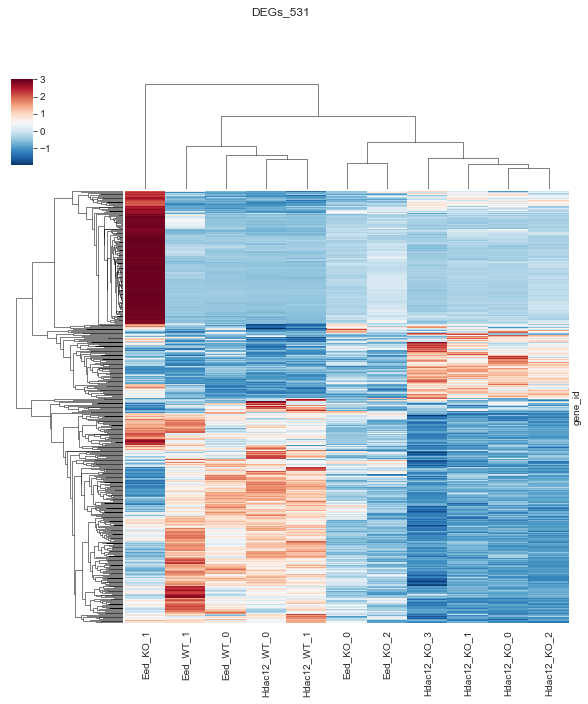

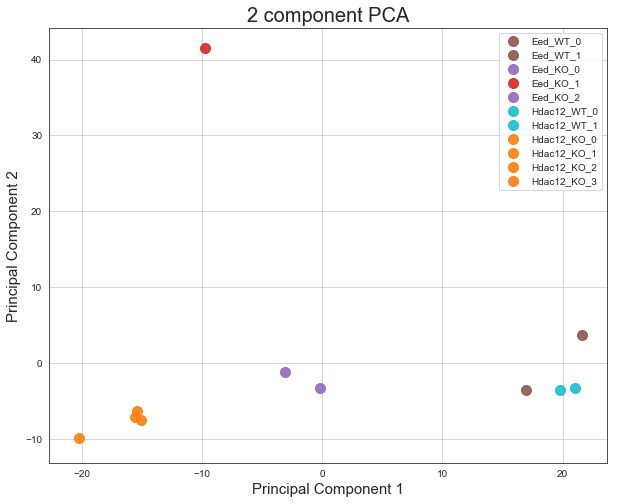

In [98]:
PCA_heatmap(df_DEGs)

## From above we can continue using:
# "df_ALL_DEGs" for plot

# Plot Part

In [7]:
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline

# Venn 2 and 3D

In [5]:
def Generate_Venn_Diagram(Raw_Path, Out_Path, Merge_Column):
    from matplotlib_venn import venn2
    
    DIR_CHECK_CREATE(Raw_Path)
    DIR_CHECK_CREATE(Out_Path)
    Merge_Column='gene_id'
    
    INPUT_LIST=os.listdir(RAW_PATH)
    FILE_TYPE=INPUT_LIST[0][-4:]
    print('Input File: ' )
    print(INPUT_LIST)
    
    if len(INPUT_LIST) == 2:
        print ('Input Two, Continue.')
        PATH_A = RAW_PATH + '/' +INPUT_LIST[0]
        PATH_B = RAW_PATH + '/' +INPUT_LIST[1]

        df_A = pd.read_csv(PATH_A,sep='\t')
        df_B = pd.read_csv(PATH_B,sep='\t')

        ### Union A and B, use indicator to differentiate them.
        union_A_B=df_A.loc[:, [Merge_Column]].merge(df_B.loc[:,[Merge_Column]], how='outer', indicator=True)

        intersection_A_B=union_A_B[union_A_B['_merge']=='both']
        only_A=union_A_B[union_A_B['_merge']=='left_only']
        only_B=union_A_B[union_A_B['_merge']=='right_only']

        #Output
        intersection_A_B.to_csv(OUT_PATH+'/Intersection_'+INPUT_LIST[0][:-4]+'_'+INPUT_LIST[1][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
        only_A.to_csv(OUT_PATH+'/Only_'+INPUT_LIST[0][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
        only_B.to_csv(OUT_PATH+'/Only_'+INPUT_LIST[1][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
        union_A_B.to_csv(OUT_PATH+'/Union_'+INPUT_LIST[0][:-4]+'_'+INPUT_LIST[1][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
    else:
        print('Error!')
        print('Input '+str(len(INPUT_LIST))+ ' Files')


    out = venn2(subsets=(len(only_A[Merge_Column]), len(only_B[Merge_Column]), len(intersection_A_B[Merge_Column])),
          set_labels=(INPUT_LIST[0][:-4], INPUT_LIST[1][:-4] ) )
    for text in out.subset_labels:
        text.set_fontsize(18)
    plt.show()
    
def Generate_Venn3_Diagram(Raw_Path, Out_Path, Merge_Column):
    from matplotlib_venn import venn3, venn3_circles
    
    DIR_CHECK_CREATE(Raw_Path)
    DIR_CHECK_CREATE(Out_Path)
    Merge_Column='gene_id'
    
    INPUT_LIST=os.listdir(RAW_PATH)
    FILE_TYPE=INPUT_LIST[0][-4:]
    print('Input File: ' )
    print(INPUT_LIST)
    
    if len(INPUT_LIST) == 3:
        print ('Input Three, Continue.')
        PATATH_A = RAW_PATH + '/' +INPUT_LIST[0]
        PATH_B = RAW_PATH + '/' +INPUT_LIST[1]
        PATH_C = RAW_PATH + '/' +INPUT_LIST[2]

        ConA=INPUT_LIST[0][:-4]
        ConB=INPUT_LIST[1][:-4]
        ConC=INPUT_LIST[2][:-4]

        df_A = pd.read_csv(PATH_A,sep='\t')
        df_B = pd.read_csv(PATH_B,sep='\t')
        df_C = pd.read_csv(PATH_C,sep='\t')

        Merge_Column='gene_id'

        union_A_B_C = df_C.loc[:, [Merge_Column]].merge( df_A.loc[:, [Merge_Column]].merge(df_B.loc[:,[Merge_Column]], how='outer'), how='outer')

        intersection_metrix=np.zeros( (len(union_A_B_C),3), dtype=int)


        for j in range(len(union_A_B_C)):
            if (union_A_B_C.loc[j,'gene_id'] in df_A.loc[:,'gene_id']):
                intersection_metrix[j,0] == 1
            if (union_A_B_C.loc[j,'gene_id'] in df_B.loc[:,'gene_id']):
                intersection_metrix[j,1] == 1
            if (union_A_B_C.loc[j,'gene_id'] in df_C.loc[:,'gene_id']):
                intersection_metrix[j,2] == 1

        intersection_metrix = pd.DataFrame(union_A_B_C['gene_id'].isin(df_A['gene_id']))
        intersection_metrix = pd.concat([intersection_metrix.rename(columns={'gene_id':ConA}),union_A_B_C['gene_id'].isin(df_B['gene_id'])], axis=1, join='inner')
        intersection_metrix = pd.concat([intersection_metrix.rename(columns={'gene_id':ConB}),union_A_B_C['gene_id'].isin(df_C['gene_id'])], axis=1, join='inner')
        intersection_metrix = intersection_metrix.rename(columns={'gene_id':ConC})

        intersection_metrix = intersection_metrix*1


        intersection_metrix ['ABC'] = intersection_metrix.iloc[:,0]+intersection_metrix.iloc[:,1]+intersection_metrix.iloc[:,2]
        intersection_metrix ['AB'] = intersection_metrix.iloc[:,0]+intersection_metrix.iloc[:,1]
        intersection_metrix ['AC'] = intersection_metrix.iloc[:,0]+intersection_metrix.iloc[:,2]
        intersection_metrix ['BC'] = intersection_metrix.iloc[:,1]+intersection_metrix.iloc[:,2]
        #intersection_metrix
        ABC = len(intersection_metrix[intersection_metrix['ABC']==3])
        AB = len(intersection_metrix[intersection_metrix['AB']==2])   -ABC
        BC = len(intersection_metrix[(intersection_metrix['BC']==2)]) -ABC
        AC = len(intersection_metrix[(intersection_metrix['AC']==2)]) -ABC

        A_solo = len(df_A) - ABC - AC - AB 
        B_solo = len(df_B) - ABC - BC - AB 
        C_solo = len(df_C) - ABC - AC - BC
    else:
        print('Error!')
        print('Input '+str(len(INPUT_LIST))+ ' Files')
        
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,8))
    out = venn3(subsets = (A_solo, B_solo, AB, C_solo, AC, BC,ABC), \
    set_labels = (ConA, ConB, ConC))
    for text in out.subset_labels:
        text.set_fontsize(18)



In [ ]:
Folder_Name='Down'
RAW_PATH=os.getcwd() + '/genelist/Venn/' + Folder_Name
OUT_PATH=os.getcwd() + '/genelist/Venn/Results_' + Folder_Name

Generate_Venn3_Diagram(RAW_PATH, OUT_PATH, 'gene_id')

Dir Exists
Dir Exists
Input File: 
['up_DKO_0h_vs_WT_0h.bed', 'Up_DKO_CD8_0h_over_WT_CD8_0h_ZZ.bed']
Input Two, Continue.


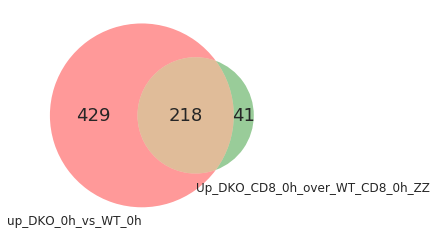

In [14]:
Folder_Name='Up'
RAW_PATH=os.getcwd() + '/Venn_Results_WT_0h_DKO_0h_vs_ZZ_2016/' + Folder_Name
OUT_PATH=os.getcwd() + '/Venn_Results_WT_0h_DKO_0h_vs_ZZ_2016/Results_' + Folder_Name

Generate_Venn_Diagram(RAW_PATH, OUT_PATH, 'gene_id')

In [28]:
#df_all
#df_ALL_DEGs


# heatmap

(16856, 11)

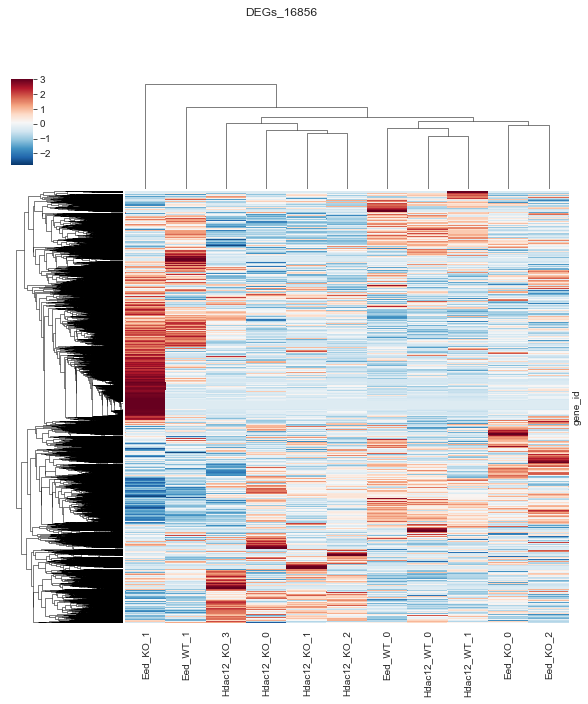

In [29]:
### Drop all zeros rows for plot
df_tem = df_ALL_DEGs
Heatmap_Df = df_tem.loc[(df_tem!=0).any(axis=1)]

Heatmap_Name='DEGs_'+str(len(Heatmap_Df.index))
#### Very Important

#Heatmap_Df=FPKM_df.fillna(0)

fig_1 = sns.clustermap(Heatmap_Df,  yticklabels=False, z_score=0, col_cluster=True, cmap='RdBu_r' )
fig_1.savefig(Heatmap_Name+'.png')
fig_1.fig.suptitle(Heatmap_Name)
Heatmap_Df.shape

# PCA



## Input a DataFrame then plot.

In [33]:
# PCA
df_2 = df_ALL_DEGs #.reset_index()

#### Remove unicode of list in python 
df2_gene_id = [x.encode('ascii', 'ignore') for x in df_2.index]


from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

#### In here we set targets as the name of columns, which means our purpose is to compare \
#### the relationship between different columns.
targets= [x.encode('ascii', 'ignore') for x in df_2.columns]

colors=[]
for i in range(len(targets)):
    colors.append( "C"+ str(i))
    #print(colors[i])

################################################################################

df_2_T = df_2.transpose()

# Separating out the features
x = df_2_T.loc[ :, df2_gene_id ].values


# Separating out the target
y = df_2_T.loc[targets,:].values


# Standardizing the featuresbio
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


########### THIS is fucking killing me. reindex df with df2, just using following command.
principalDf.index = df_2_T.index

#finalDf = pd.concat( [principalDf, df_2_T.loc['target']], axis = 1)
principalDf

,principal component 1,principal component 2
Eed_WT_0,16.954764,-3.477434
Eed_WT_1,21.603511,3.691825
Eed_KO_0,-0.197229,-3.255987
Eed_KO_1,-9.785572,41.473844
Eed_KO_2,-3.082363,-1.127632
Hdac12_WT_0,21.019142,-3.239308
Hdac12_WT_1,19.760730,-3.471914
Hdac12_KO_0,-15.053977,-7.426428
Hdac12_KO_1,-15.587654,-7.051295
Hdac12_KO_2,-15.403975,-6.232757


(531, 11)

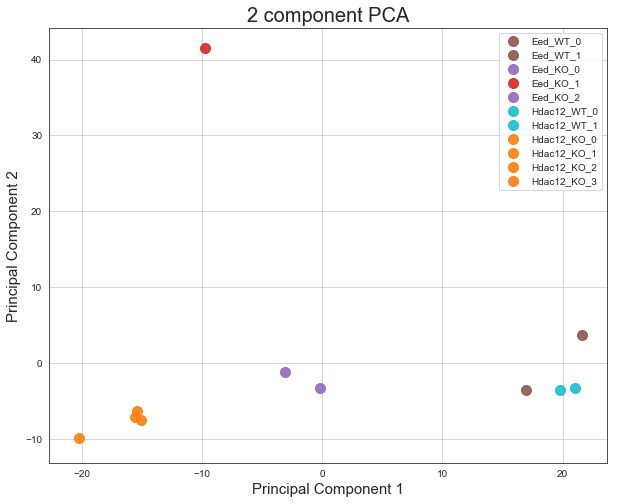

In [34]:
### PLOT

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

colors = ['C5','C5',
          'C4','C3','C4',
          'C9','C9',
          'C1','C1','C1','C1',
          'C0','C1', 
          'C6','C6','C6',
          'C2','C2','C2',
          'C3','C3','C3']

for target, color in zip( targets,colors):
    indicesToKeep = principalDf.index == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , s = 100, c=color, alpha=0.9)
ax.legend(targets)
#ax.set_xlim(-2,8)
ax.grid()
Parameters_Detail='xx'
fig.savefig('PCA'+Parameters_Detail+'.png')
df_ALL_DEGs.shape

## Violin Plot

In [29]:
all_data=[np.log1p((df3.iloc[:,0])), np.log1p((df2.iloc[:,0]))]

y_max, y_min = (max( [max(x)  for x in all_data ]), min( [min(x)  for x in all_data ]))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axes.violinplot( all_data,showmeans=False,showmedians=True)
axes.grid(color='grey', linestyle='dashed', linewidth=0.5)
#axes.set_xlabel('Frequency')
axes.set_ylabel('log1p(RPKM)')
axes.set_ylim(y_min-1,y_max+1)



plt.setp(axes, xticks=[y + 1 for y in range(len(all_data))],
         xticklabels=['Intersection_'+str(len(all_data[0])), 'Only_Tcf1_'+str(len(all_data[1]))])



from scipy import stats
MWU, pvalue = ( stats.mannwhitneyu((df3.iloc[:,0]), (df2.iloc[:,0]), alternative=None )[0], 
                stats.mannwhitneyu((df3.iloc[:,0]), (df2.iloc[:,0]), alternative='two-sided')[1])
#print "U= %d p = %.1e" % (MWU, pvalue)

if float("%.1e" % pvalue) == 1.0:
    plt.text(0.1, r'p = 1.0', fontsize=15)
    print('P_value is: %.1e' % pvalue )
else:
    if pvalue !=0:
        sign = '='
        digit, exp = re.search(r'(\S+)e(\S+)' , '%.1e' % pvalue).group(1,2)
    else:
        sign, digit, exp = '<', '1.0', '-300'
        print('P_value is: %.1e' % pvalue )
        plt.text( 1.1, (y_max+0.5) , r'P_value {} {} x $10^{{{}}}$'.format(sign, digit, int(exp)), fontsize=15)
        

NameError: name 'df3' is not defined

In [ ]:
df0_a = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_CD4_TCF1_20160827000_genelist_Only_Foxp3_5k.csv', sep='\t', header=0)
df0_a = df0_a.set_index('gene_id').dropna(axis=0, how='any')
df0_a = df0_a.loc[ (df0_a['RPKM'] > 0 ) ]
df0_a = df0_a.rename(columns={'RPKM':'RPKM_WT_Only_Foxp3'})

df0_b = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_TKOCD4_TCF1_20160827000_genelist_Only_Foxp3_5k.csv', sep='\t', header=0)
df0_b = df0_b.set_index('gene_id').dropna(axis=0, how='any')
df0_b = df0_b.loc[ (df0_b['RPKM'] > 0 ) ]
df0_b = df0_b.rename(columns={'RPKM':'RPKM_KO_Only_Foxp3'})

###################################################################################################################
df1_a = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_CD4_TCF1_20160827000_genelist_Intersection_Foxp3_5k_Treg_TCF1.csv', sep='\t', header=0)
df1_a = df1_a.set_index('gene_id').dropna(axis=0, how='any')
df1_a = df1_a.loc[ (df1_a['RPKM'] > 0 ) ]
df1_a = df1_a.rename(columns={'RPKM':'RPKM_WT_Intersection'})

df1_b = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_TKOCD4_TCF1_20160827000_genelist_Intersection_Foxp3_5k_Treg_TCF1.csv', sep='\t', header=0)
df1_b = df1_b.set_index('gene_id').dropna(axis=0, how='any')
df1_b = df1_b.loc[ (df1_b['RPKM'] > 0 ) ]
df1_b = df1_b.rename(columns={'RPKM':'RPKM_KO_Intersection'})

###################################################################################################################
df2_a = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_CD4_TCF1_20160827000_genelist_Only_Treg_TCF1.csv', sep='\t', header=0)
df2_a = df2_a.set_index('gene_id').dropna(axis=0, how='any')
df2_a = df2_a.loc[ (df2_a['RPKM'] > 0 ) ]
df2_a = df2_a.rename(columns={'RPKM':'RPKM_WT_Only_Treg'})

df2_b = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_TKOCD4_TCF1_20160827000_genelist_Only_Treg_TCF1.csv', sep='\t', header=0)
df2_b = df2_b.set_index('gene_id').dropna(axis=0, how='any')
df2_b = df2_b.loc[ (df2_b['RPKM'] > 0 ) ]
df2_b = df2_b.rename(columns={'RPKM':'RPKM_KO_Only_Treg'})

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))

axes[0,0].violinplot(  (np.log10(df0_a.iloc[:,0])),showmeans=False,showmedians=True )
axes[0,0].set_title('gene_list_WT_Only_FoxP3_'+str(len(df0_a)))

axes[1,0].violinplot( ( np.log10(df0_b.iloc[:,0] )),showmeans=False,showmedians=True)
axes[1,0].set_title('gene_list_KO_Only_FoxP3_'+str(len(df0_b)))



axes[0,1].violinplot( ( np.log10(df1_a.iloc[:,0] )),showmeans=False,showmedians=True)
axes[0,1].set_title('gene_list_WT_Intersection_'+str(len(df1_a)))

axes[1,1].violinplot( ( np.log10(df1_b.iloc[:,0] )),showmeans=False,showmedians=True)
axes[1,1].set_title('gene_list_KO_Intersection_'+str(len(df1_b)))



axes[0,2].violinplot( ( np.log10(df2_a.iloc[:,0] )),showmeans=False,showmedians=True)
axes[0,2].set_title('gene_list_WT_Only_Treg_'+str(len(df2_a)))

axes[1,2].violinplot( ( np.log10(df2_b.iloc[:,0] )),showmeans=False,showmedians=True)
axes[1,2].set_title('gene_list_KO_Only_Treg_'+str(len(df2_b)))



for i in range(2):
    for j in range(3):
        ax=axes[i,j]
        ax.yaxis.grid(True)
        #ax.set_xticks([y + 1 for y in range(max(df1))])
        ax.set_ylim(-0.5,2)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('log10(RPKM)')

fig.savefig('gene_list_WT_KO.png') 

# Scattering Plot + Heatmap

In [104]:
def hexbin_with_density(df, highlight_name, title_name, density_scale, drop_top_outlier):
    ### drop outlier
    import re
    df = df.drop(df.iloc[:,0].nlargest(n=drop_top_outlier,keep='first').index)
    
    
    range_limit=df.max().max()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9), sharex=False, sharey=False)
    
    if density_scale == 'log':
        hb = ax.hexbin(df.iloc[:,[0]], df.iloc[:,[1]], gridsize=(100,100), cmap=plt.cm.jet,
                   bins='log',mincnt=1,alpha=2, edgecolors='face')
        cb = fig.colorbar(hb,ax=ax)
        cb.set_label('Log$_{10}$(1+Counts)', fontsize=18)
    else:
        hb = ax.hexbin(df.iloc[:,[0]], df.iloc[:,[1]], gridsize=(100,100), cmap=plt.cm.jet,
                   mincnt=1,alpha=2, edgecolors='face')
        cb = fig.colorbar(hb,ax=ax)
        cb.set_label('Counts', fontsize=18)

    ###  highlight a point
    if len(highlight_name) >= 1:
        for highlight_index in highlight_name[:]:
            ax.scatter(df[df.index == highlight_index].iloc[:,[0]],
                        df[df.index == highlight_index].iloc[:,[1]],
                        alpha=1.0,s=50,color='red', label=highlight_index,edgecolor='red')
            ax.text(df[df.index == highlight_index].iloc[:,0]-range_limit/20.0,
                      df[df.index == highlight_index].iloc[:,1]+range_limit/25.0, highlight_index, fontsize=16, color='r')


    ax.yaxis.grid(False)
    ax.set_ylim(-0.1*range_limit,range_limit+0.1*range_limit)
    ax.set_xlim(-0.1*range_limit,range_limit+0.1*range_limit)
    ax.set_xlabel(str(df.columns[0]), fontsize=18)
    ax.set_ylabel(str(df.columns[1]), fontsize=18)
    ax.plot([-0.1*range_limit,range_limit+0.1*range_limit], [-0.1*range_limit, range_limit+0.1*range_limit], ls="--", c="gray")
    ax.set_title(str(len(df))+ ': '+ title_name , fontsize=18)
    
    
    
    from scipy.stats import pearsonr
    r, pvalue = ( pearsonr((df.iloc[:,0]), (df.iloc[:,1]))[0], 
                    pearsonr((df.iloc[:,0]), (df.iloc[:,1]))[1])
    #print "U= %d p = %.1e" % (MWU, pvalue)

    
    print df.iloc[:,[0,1]].columns[0],"&", df.iloc[:,[0,1]].columns[1]
    if float("%.1e" % pvalue) == 1.0:
        plt.text(range_limit/2-0.1*range_limit, range_limit+0.17*range_limit, r'p = 1.0', fontsize=15)
        print('Pearson_r is: %.1e' % round(r,4) )
        print('P_value is: %.1e' % pvalue )
    else:
        if pvalue !=0:
            sign = '='
            digit, exp = re.search(r'(\S+)e(\S+)' , '%.1e' % pvalue).group(1,2)
            plt.text(range_limit/2-0.35*range_limit, range_limit+0.17*range_limit, r'Pearson_r {} {} with P_value {} {} x $10^{{{}}}$'.format(sign, round(r,4), sign, digit, int(exp)), fontsize=15)
            print('Pearson_r is: %.4f' % r )
            print('P_value is: %.1e' % pvalue )
        else:
            sign, digit, exp = '<', '1.0', '-300'
            plt.text(range_limit/2-0.35*range_limit, range_limit+0.17*range_limit, r'Pearson_r {} {} with P_value {} {} x $10^{{{}}}$'.format(sign, round(r,4), sign, digit, int(exp)), fontsize=15)
            print('Pearson_r is: %.4f' % r )
            print('P_value is: %.1e' % pvalue )
    return 0

In [101]:
df_ALL_DEGs.columns

Index([u'Eed_WT_1', u'Eed_WT_0', u'Eed_KO_0', u'Eed_KO_1', u'Eed_KO_2',
       u'Hdac12_WT_1', u'Hdac12_WT_0', u'Hdac12_KO_0', u'Hdac12_KO_1',
       u'Hdac12_KO_2', u'Hdac12_KO_3'],
      dtype='object')

Hdac12_KO_1 & Hdac12_KO_2
Pearson_r is: 0.9621
P_value is: 1.4e-308


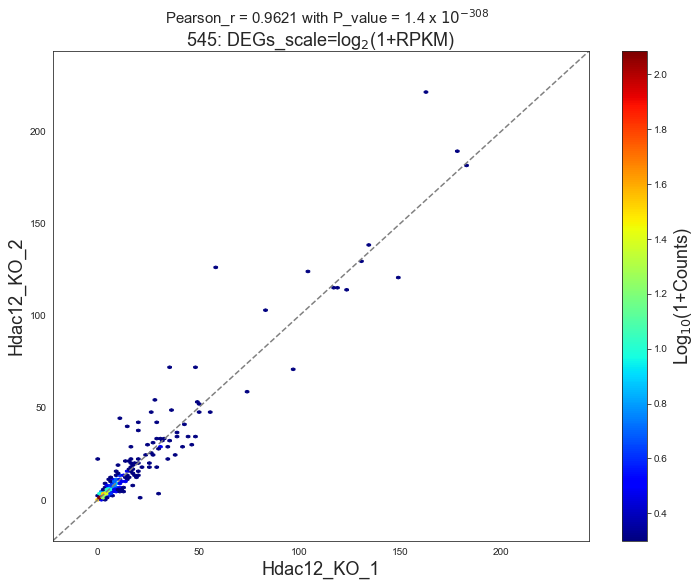

In [114]:
aa = hexbin_with_density(df_ALL_DEGs.iloc[:,[8,9]],'', 'DEGs_scale=log$_2$(1+RPKM)', 'log',0)


'Eed_WT_1'

In [ ]:
from scipy.stats import gaussian_kde
        # Calculate the point density
    fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=True)

    range_limit=1000
    xy = np.vstack([df_gene_Intersection_WT, df_gene_Intersection_KO])
    z = gaussian_kde(xy)(xy)

    axis[1].axis('equal')
    cax_1 = axis[1].scatter(df_gene_Intersection_WT, df_gene_Intersection_KO, alpha=1.0,s=5,c=z, label='Intersection',edgecolor='')
    
    ###  highlight a point
    highlight_index='Tcf7'
    axis[1].scatter(df_gene_Intersection_WT[df_gene_Intersection_WT.index == highlight_index],
                df_gene_Intersection_KO[df_gene_Intersection_KO.index == highlight_index],
                alpha=1.0,s=50,color='blue', label=highlight_index,edgecolor='blue')
    axis[1].text(df_gene_Intersection_WT[df_gene_Intersection_WT.index == highlight_index]+range_limit/20,
                df_gene_Intersection_KO[df_gene_Intersection_KO.index == highlight_index]-range_limit/20, highlight_index, fontsize=14)
    ###
    
    axis[1].set_title('Intersection: '+ str(len(df_gene_Intersection_WT)) + ' elements')
    axis[1].plot([0,range_limit], [0, range_limit], ls="--", c=".3")
    
    
    
    
    axis[0].axis('equal')
    xy = np.vstack([df_gene_Only_Foxp3_WT, df_gene_Only_Foxp3_KO])
    z = gaussian_kde(xy)(xy)
    cax_0 = axis[0].scatter(df_gene_Only_Foxp3_WT, df_gene_Only_Foxp3_KO, alpha=1.0,s=5, c=z, label='Only_Foxp3',edgecolor='')
    axis[0].set_title('Only_Foxp3: ' + str(len(df_gene_Only_Foxp3_WT))+' elements')
    axis[0].plot([0,range_limit], [0, range_limit], ls="--", c=".3")
    

    axis[2].axis('equal')
    xy = np.vstack([df_gene_Only_Tcf1_WT, df_gene_Only_Tcf1_KO])
    z = gaussian_kde(xy)(xy)
    cax_2 = axis[2].scatter(df_gene_Only_Tcf1_WT, df_gene_Only_Tcf1_KO, alpha=1.0,s=5, c=z, label='Only_Tcf1',edgecolor='')
    axis[2].set_title( 'Only_Tcf1: '+str(len(df_gene_Only_Tcf1_WT))+' elements')
    axis[2].plot([0,range_limit], [0, range_limit], ls="--", c=".3")
    
    for ax in axis:
            ax.yaxis.grid(True)
            ax.set_ylim(-50,range_limit)
            ax.set_xlim(-50,range_limit)
            ax.set_xlabel('WT_RPKM')
            ax.set_ylabel('KO_RPKM')

fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7]) # A 4-length sequence of [left, bottom, width, height] quantities.
#fig.colorbar(cax=cbar_ax)



    